Preamble: import these plotting utilities

In [375]:
import numpy as np

# Wipe all outputs from this notebook
from IPython.display import Image, clear_output, display
clear_output(True)

# Import local plotting functions and in-notebook display functions
import matplotlib.pyplot as plt
%matplotlib inline


# First passage times on the network of collaborators

We can see that the random walk is biased towards nodes with high degree (many collaborators). That means that the ensemble of random walks has non-uniform measure on the graph of collaborators.

Suppose we start out at the node with the highest degree. How long does it take to reach a given node? This is equivalent to the first passage time problem for a random walk on the graph.

We naively expect that the first passage time is proportional to the degree of the node. That is, the more collaborators an author has, the more likely it is that we will collaborate with them after a fixed number of steps

We will compare the first passage time between the most highly-connected node (most collaborators) and the second-most highly-connected node (second-most collaborators), as compared to the first passage time between the most highly-connected node and a less-connected node (fewer collaborators).

In [137]:
class FirstPassageTime(GraphRandomWalk):
    """A class for computing the first passage time distribution

    Parameters:
        A (np.ndarray): The adjacency matrix of the graph
        random_state (int): The random seed to use
        max_iter (int): The maximum number of iterations to use
    """

    def __init__(self, A, max_iter=10000, random_state=None, store_history=False):
        self.A = A
        self.max_iter = max_iter
        self.random_state = random_state
        self.store_history = store_history
        np.random.seed(self.random_state)

        if self.store_history:
            self.history = []


    def fpt(self, start, stop):
        """Compute the first passage time distribution

        Args:
            start (int): The starting node
            stop (int): The stopping node
            steps (int): The maximum number of steps to take

        Returns:
            fpt (int): The first passage time
        """
        curr = start
        if self.store_history:
            self.history.append(start)
        for i in range(self.max_iter):
            curr = self.step(curr)
            if self.store_history:
                self.history.append(curr)
            if curr == stop:
                return i

        return np.inf

fpt = FirstPassageTime(A, random_state=0, store_history=True, max_iter=100000)
fpt.fpt(0, 10)

2768

In [170]:
all_paths_close, all_fpts_close = [], []
all_paths_far, all_fpts_far = [], []

for _ in range(1000):
    fpt = FirstPassageTime(A, store_history=True, max_iter=100000)
    all_fpts_close.append(fpt.fpt(0, 1))
    all_paths_close.append(fpt.history)

    fpt = FirstPassageTime(A, store_history=True, max_iter=100000)
    all_fpts_far.append(fpt.fpt(0, 15))
    all_paths_far.append(fpt.history)

# print number that didn't converge within max_iter
print("Number of paths that didn't converge within max_iter: {}".format(np.sum(np.isinf(all_fpts_close))))
print("Number of paths that didn't converge within max_iter: {}".format(np.sum(np.isinf(all_fpts_far))))

Number of paths that didn't converge within max_iter: 0
Number of paths that didn't converge within max_iter: 0


Mean FPT for less collaborative authors: 10621.12
Mean FPT for highly collaborative authors: 2254.71


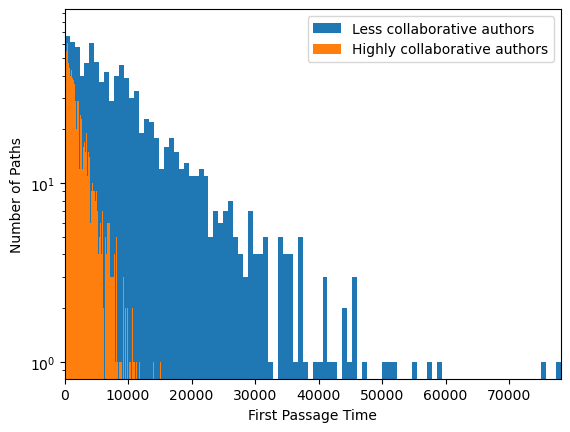

In [179]:
plt.semilogy()
plt.hist(all_fpts_far, bins=100, alpha=1, label="Less collaborative authors");
plt.hist(all_fpts_close, bins=100, alpha=1, label="Highly collaborative authors");
plt.xlabel("First Passage Time")
plt.ylabel("Number of Paths")
plt.xlim([0, np.max(all_fpts_far)])
plt.legend()

print("Mean FPT for less collaborative authors: {:.2f}".format(np.mean(all_fpts_far)))
print("Mean FPT for highly collaborative authors: {:.2f}".format(np.mean(all_fpts_close)))


We can compare the distribution of paths between the most highly-connected node and the second-most highly-connected node, as compared to the distribution of paths between the most highly-connected node and a less-connected node.

We plot one distribution in red, and the other in blue, to see how they compare.

(-0.8387362360954285,
 1.0875588059425354,
 -0.7460978388786316,
 0.915596878528595)

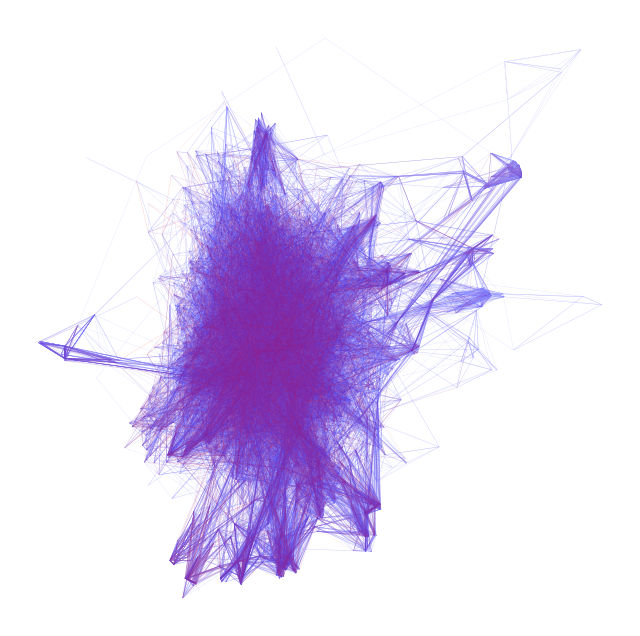

In [270]:
plt.figure(figsize=(8, 8))
for traj1, traj2 in zip(all_paths_far[:10], all_paths_close[:100]):
    traj1 = [pos[item] for item in traj1]
    traj2 = [pos[item] for item in traj2]
    plt.plot(*zip(*traj1), color='b', linewidth=.3, alpha=0.1)
    plt.plot(*zip(*traj2), color='r', linewidth=.3, alpha=0.1)
plt.axis('off')

# Can we compute this analytically?

We can now compute the first passage time analytically. Much as we previously saw with random walks on the line, we can pass between the dynamics of single walkers (particles), and the dynamics of a distribution (ensemble). From the adjacency matrix $A$, we can construct a transition matrix $T$ such that

$$
T_{ij} = \frac{A_{ij}}{\sum_k A_{ik}}
$$

This matrix defines a discrete-time Markov chain on the graph. Given a *starting distribution* $\pi_0 \in \mathbb{R}^N$, we can compute the distribution of the random walk after $n$ steps as

$$
\pi_n = T^n \pi_0 
$$

where $\pi_n$ is the distribution of the random walk after $n$ steps, and $T^n$ is the transition matrix applied $n$ times.

In the case above, our starting distribution is $\pi_0 = \delta_{i, \text{max}}$, where $\delta_{i, \text{max}}$ is the Kronecker delta function, which is 1 if $i = \text{max}$ and 0 otherwise. That is, we always start out at the node with the highest degree.


In [172]:
# make the transition matrix from the adjacency matrix

# normalize the adjacency matrix
D = np.diag(np.sum(A, axis=0))
T = np.linalg.inv(D) @ A


We are now ready to solve for the first passage time analytically. We have already seen two matrices, the adjacency matrix $A$ and the transition matrix $T$. We now introduce the *first passage time matrix* $F$.The $(i, j)$ entry of $F$ is the *expected* number of steps it takes to reach node $j$ from node $i$. In other words, on average we expect to reach node $j$ after $F_{ij}$ steps.

We can write down this matrix in terms of the transition matrix $T$ as

$$
F_{ij} = \delta_{ij} + \sum_{k \neq j} T_{ik} (F_{kj} + 1)
$$

We can interpret this matrix equation as follows: the first passage time from node $i$ to node $j$ is 1 if $i = j$ (we are already at node $j$), and otherwise it is the sum of the first passage times from node $k$ to node $j$, times the probability of transitioning from node $i$ to node $k$.

This recursive equation captures the intution that a walker starting at $i$ has a probability $T_{ik}$ of transitioning to each of the other nodes $k$, and each of those nodes has its own associated first passage time $F_{kj}$. However, because it takes at least one step to transition from $i$ to $k$, we add 1 to the first passage time from $k$ to $j$.

We can re-write this equation in matrix form as

$$
F = I + T (F + I)
$$

Solving, we find

$$
F = (I - T)^{-1}
$$

where $I$ is the identity matrix. We can now compute the first passage time from node $i$ to node $j$ as $F_{ij}$.

Let's compute the first passage time matrix $F$ for the graph of `astro-ph` coauthorship.


In [184]:
# check that the rows sum to 1
np.sum(T, axis=1)

# compute the first passage time distribution
fpt = np.linalg.inv(np.identity(T.shape[0]) - T)

print("Mean FPT for less collaborative authors: {:.2f}".format(fpt[0, 1]))
print("Mean FPT for highly collaborative authors: {:.2f}".format(fpt[0, 15]))

Mean FPT for less collaborative authors: 19717690204756.06
Mean FPT for highly collaborative authors: 3904493109852.69


In [342]:
# PageRank centrality

# normalize the adjacency matrix
D = np.diag(np.sum(A, axis=0))
T = np.linalg.inv(D) @ A

d = 0.85 # damping factor (probability of following a link)
page_rank = np.linalg.inv(np.identity(T.shape[0]) - d * A @ np.linalg.inv(D)) @ np.ones((T.shape[0], 1))

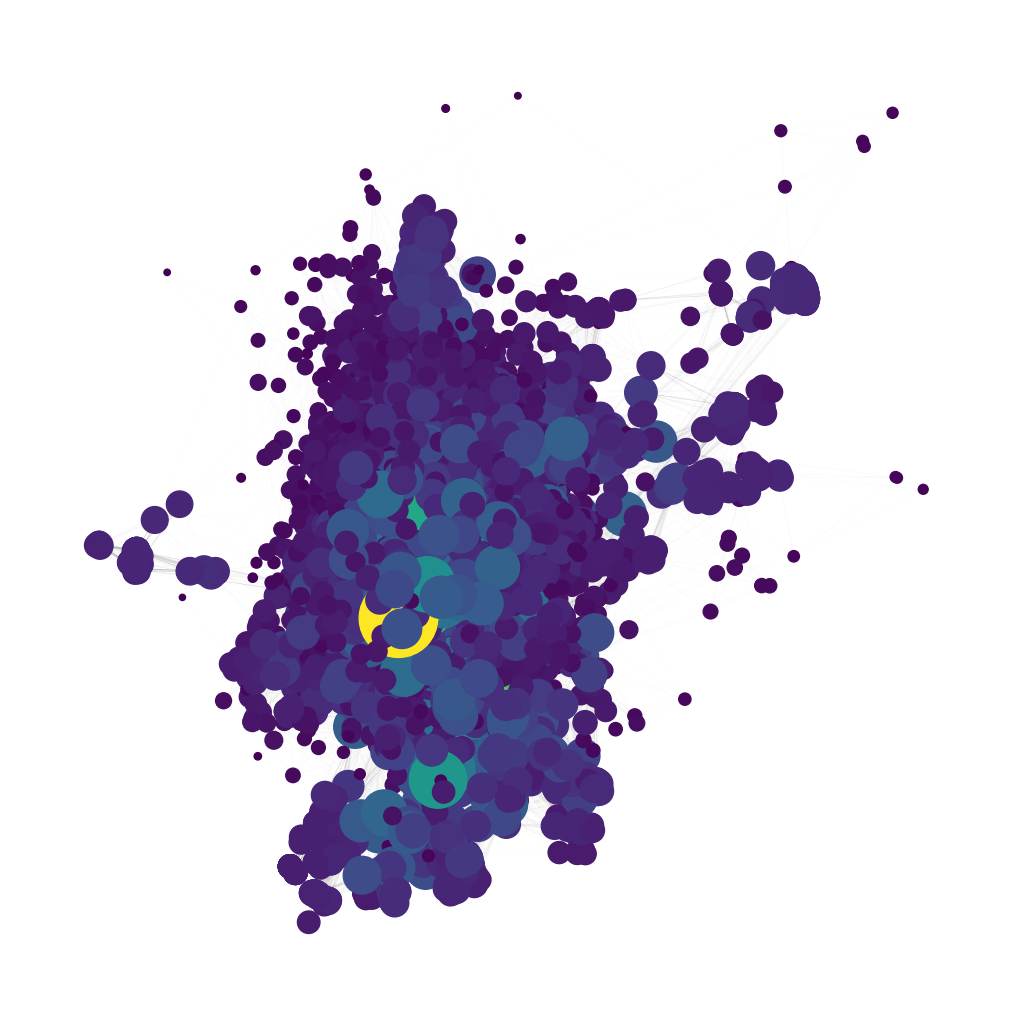

Text(0, 0.5, 'PageRank')

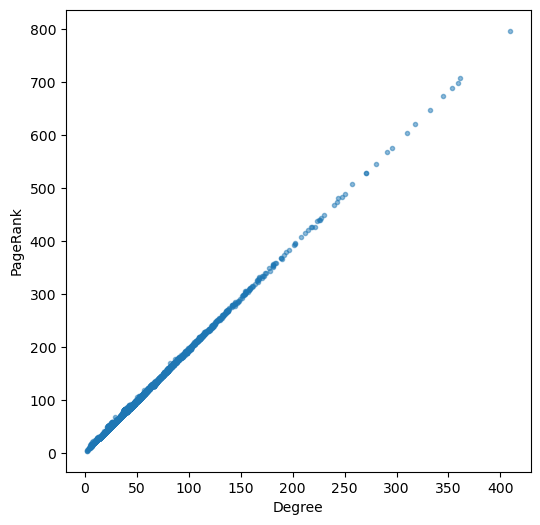

In [341]:
# plot matrix with networkx with node size proportional to and colored by page rank centrality
plt.figure(figsize=(10, 10))
nx.draw(g2, pos=pos, node_size=page_rank*4, node_color=page_rank, edge_color='gray', width=0.01, cmap='viridis')
plt.show()

# compare pagerank and degree centrality
plt.figure(figsize=(6, 6))
plt.plot(degrees, page_rank, '.', alpha=0.5)
plt.xlabel("Degree")
plt.ylabel("PageRank")